In [1]:
# For colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Part 1: Importing the libraries

In [0]:
import numpy as np
import math
import re
import time
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds #for tokenization
import matplotlib.pyplot as plt

# Part 2: Data preprocessing

## 2.1 Importing data

In [0]:
with open("/content/gdrive/My Drive/projects/transformer/data/europarl-v7.fr-en.en",
          mode = "r", 
          encoding = "utf-8") as f:
          europarl_en = f.read()
with open("/content/gdrive/My Drive/projects/transformer/data/europarl-v7.fr-en.fr",
          mode = "r", 
          encoding = "utf-8") as f:
          europarl_fr = f.read()
with open("/content/gdrive/My Drive/projects/transformer/data/nonbreaking_prefix.en",
          mode = "r", 
          encoding = "utf-8") as f:
          non_breaking_prefix_en = f.read()
with open("/content/gdrive/My Drive/projects/transformer/data/nonbreaking_prefix.fr", # ex: "." in A.B.C is a non breaking prefix
          mode = "r", 
          encoding = "utf-8") as f:
          non_breaking_prefix_fr = f.read()                              

In [4]:
europarl_en[:100]

'Resumption of the session\nI declare resumed the session of the European Parliament adjourned on Frid'

In [5]:
europarl_fr[:100]

'Reprise de la session\nJe déclare reprise la session du Parlement européen qui avait été interrompue '

## 2.2 Cleaning data

### 2.2.1 Non-breaking prefix

Let's see the non-breaking prefix in English



In [6]:
non_breaking_prefix_en

'a\nb\nc\nd\ne\nf\ng\nh\ni\nj\nk\nl\nm\nn\no\np\nq\nr\ns\nt\nu\nv\nw\nx\ny\nz\nmessrs\nmlle\nmme\nmr\nmrs\nms\nph\nprof\nsr\nst\na.m\np.m\nvs\ni.e\ne.g'

Let's see the non-breaking prefix in French

In [7]:
non_breaking_prefix_fr

'a\nb\nc\nd\ne\nf\ng\nh\ni\nj\nk\nl\nm\nn\no\np\nq\nr\ns\nt\nu\nv\nw\nx\ny\nz\nmme\nmlle\nc.-à-d\ncf\nchap\ne.g\nal\netc\nex\nfig\nsuiv\nsup\nsuppl\ntél\nvol\nvs'

Splitting the non_breaking_prefixs as a clean list of words with a space at before and a point at the end. This means that " a." is not the end of a sentence (For exemple, "The company A.B.C")

In [0]:
#for english
non_breaking_prefix_en = non_breaking_prefix_en.split("\n") 
non_breaking_prefix_en = [' ' +  pref + '.' for pref in non_breaking_prefix_en]
#for french
non_breaking_prefix_fr = non_breaking_prefix_fr.split("\n") 
non_breaking_prefix_fr = [' ' +  pref + '.' for pref in non_breaking_prefix_fr]

In [9]:
non_breaking_prefix_en

[' a.',
 ' b.',
 ' c.',
 ' d.',
 ' e.',
 ' f.',
 ' g.',
 ' h.',
 ' i.',
 ' j.',
 ' k.',
 ' l.',
 ' m.',
 ' n.',
 ' o.',
 ' p.',
 ' q.',
 ' r.',
 ' s.',
 ' t.',
 ' u.',
 ' v.',
 ' w.',
 ' x.',
 ' y.',
 ' z.',
 ' messrs.',
 ' mlle.',
 ' mme.',
 ' mr.',
 ' mrs.',
 ' ms.',
 ' ph.',
 ' prof.',
 ' sr.',
 ' st.',
 ' a.m.',
 ' p.m.',
 ' vs.',
 ' i.e.',
 ' e.g.']

In [10]:
non_breaking_prefix_fr

[' a.',
 ' b.',
 ' c.',
 ' d.',
 ' e.',
 ' f.',
 ' g.',
 ' h.',
 ' i.',
 ' j.',
 ' k.',
 ' l.',
 ' m.',
 ' n.',
 ' o.',
 ' p.',
 ' q.',
 ' r.',
 ' s.',
 ' t.',
 ' u.',
 ' v.',
 ' w.',
 ' x.',
 ' y.',
 ' z.',
 ' mme.',
 ' mlle.',
 ' c.-à-d.',
 ' cf.',
 ' chap.',
 ' e.g.',
 ' al.',
 ' etc.',
 ' ex.',
 ' fig.',
 ' suiv.',
 ' sup.',
 ' suppl.',
 ' tél.',
 ' vol.',
 ' vs.']

### 2.2.2 Creating corpus of words

Creating corpus of words by covering all the words to lowercase and separting them by spaces (Tokenization).

In [0]:
#for English
corpus_en  = europarl_en
for prefix in non_breaking_prefix_en:
  corpus_en = corpus_en.replace(prefix, prefix + "###") 
corpus_en = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".###", corpus_en) # The points followed by any number or letter, 
                                                            # just consider the points for the replacement parts
                                                            # that means to replace these points by ".###"
corpus_en = re.sub(r"\.###", '', corpus_en)
corpus_en = re.sub(r"  +", " ", corpus_en) # looking for at least two white spaces in a row, 
                                           # +: looking for at least one occurence of 
                                           # the previous character. Here we want to replace 
                                           #two white spaces by one white space
corpus_en = corpus_en.split("\n")          

#for French
corpus_fr  = europarl_fr
for prefix in non_breaking_prefix_fr:
  corpus_fr = corpus_fr.replace(prefix, prefix + "###")
corpus_fr = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".###", corpus_fr) 
corpus_fr = re.sub(r"\.###", '', corpus_fr)
corpus_fr = re.sub(r"  +", " ", corpus_fr) 
corpus_fr = corpus_fr.split("\n")  

In [12]:
corpus_en[:20]

['Resumption of the session',
 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.',
 "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.",
 'You have requested a debate on this subject in the course of the next few days, during this part-session.',
 "In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.",
 "Please rise, then, for this minute' s silence.",
 "(The House rose and observed a minute' s silence)",
 'Madam President, on a point of order.',
 'You will be aware from the press and television that there have be

In [13]:
corpus_fr[:20]

['Reprise de la session',
 'Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.',
 'Comme vous avez pu le constater, le grand "bogue de l\'an 2000" ne s\'est pas produit. En revanche, les citoyens d\'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.',
 'Vous avez souhaité un débat à ce sujet dans les prochains jours, au cours de cette période de session.',
 "En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés.",
 'Je vous invite à vous lever pour cette minute de silence.',
 '(Le Parlement, debout, observe une minute de silence)',
 "Madame la Présidente, c'est une motion de procédure.",
 'Vous avez p

## 2.3 Tokenization

In [0]:
# for English 
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_en, target_vocab_size = 2**13
)

# for French
tokenizer_fr = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    corpus_fr, target_vocab_size = 2**13
)

In [0]:
VOCAB_SIZE_EN = tokenizer_en.vocab_size + 2 
                      #We will add <SOS> and <EOS> at the begining and the end of the sentences.  
VOCAB_SIZE_FR = tokenizer_fr.vocab_size + 2 


In [0]:
inputs = [[ VOCAB_SIZE_EN - 2] + tokenizer_en.encode(sentence) + [VOCAB_SIZE_EN-1]
          for sentence in corpus_en] # list of  representaions of English sentences
outputs = [[ VOCAB_SIZE_FR - 2] + tokenizer_fr.encode(sentence) + [VOCAB_SIZE_FR-1]
          for sentence in corpus_fr]  # list of  representaions of French sentences

## 2.4 Remove too long sentences

In [0]:
MAX_LENGTH = 40 # the maximum length of the sentences we choose

idx_to_remove = [count for count, sentence in enumerate(inputs)
                  if len(sentence) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]

idx_to_remove = [count for count, sentence in enumerate(outputs)
                  if len(sentence) > MAX_LENGTH]
for idx in reversed(idx_to_remove):
  del inputs[idx]
  del outputs[idx]  

## 2.5 Input creations

Batching, padding

In [0]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                       value = 0,
                                                       padding = 'post', #add zero at the end of each sentence
                                                       maxlen = MAX_LENGTH)
outputs = tf.keras.preprocessing.sequence.pad_sequences(outputs,
                                                       value = 0,
                                                       padding = 'post',
                                                       maxlen = MAX_LENGTH)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000 #shuffling dataset

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))



# cache the dataset to memory to get a speedup while reading from it.
# Improve the way that dataset is stored and the way we can have access
# to data during the training. 
# Example: we just need to open and read data once in the 1st iteration, subsequent iterations will use the cached data.
dataset =  dataset.cache() 

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput,
#at the cost of using additional memory to store prefetched elements.
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)   
#tf.data.experimental.AUTOTUNE  will prompt the tf.data runtime to tune the value dynamically at runtime.                       

In [0]:
# #save dataset to use later
# filename = '/content/gdrive/My Drive/projects/transformer/done_dataset.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(dataset)

In [21]:
en_batch, fr_batch = next(iter(dataset))
en_batch, fr_batch


(<tf.Tensor: shape=(64, 40), dtype=int32, numpy=
 array([[8188, 4247,  582, ...,    0,    0,    0],
        [8188, 1547,    2, ...,    0,    0,    0],
        [8188,   11,   88, ...,    0,    0,    0],
        ...,
        [8188, 1716, 4835, ...,    0,    0,    0],
        [8188,   11, 3004, ...,    0,    0,    0],
        [8188, 1872,    3, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 40), dtype=int32, numpy=
 array([[8169,   34,  126, ...,    0,    0,    0],
        [8169,   41,  148, ...,    0,    0,    0],
        [8169,   34,  126, ...,    0,    0,    0],
        ...,
        [8169, 7980, 7952, ...,    0,    0,    0],
        [8169,   34,  931, ...,    0,    0,    0],
        [8169, 6758,    7, ...,    0,    0,    0]], dtype=int32)>)

# Part 3: Model Building

## 3.1 Positional encoding

Positional encoding formulas:

$PE_{(pos,2i)} =\sin(pos/10000^{2i/dmodel})$

$PE_{(pos,2i+1)} =\cos(pos/10000^{2i/dmodel})$

In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


(1, 50, 512)


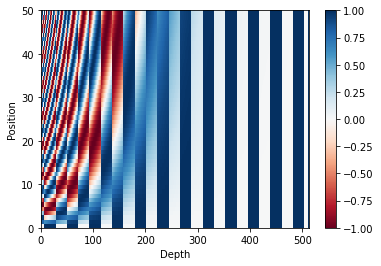

In [23]:
# test
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 3.2 Self-Attention

### 3.2.1 Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value <code>0</code> is present: it outputs a <code>1</code> at those locations, and a <code>0</code> otherwise.

In [0]:
# @tf.function ????
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [25]:
#test:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)


<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [27]:
#test
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### 3.2.2 Scaled Dot-Product attention

$Attention(Q, K, V ) = \text{softmax}\left(\dfrac{QK^T}{\sqrt{d_k}}\right)V $



![Texte alternatif…](https://drive.google.com/uc?id=1af7X7Tzb_OJj-0AXa-33N8RmiDZ4Mv-I)



In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth ( = d_k in the paper)) 
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [29]:
#test
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 0, 10], 
                      [0, 10, 0], 
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)


Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 3.2.3 Multi-head self-attention

![Texte alternatif…](https://drive.google.com/uc?id=1UwMABTI9YRbUP05zAfvDHYUD0TlEwgcI)

Multi-head attention consists of four parts:

Linear layers and split into heads.
Scaled dot-product attention.
Concatenation of heads.
Final linear layer.
Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The <code>scaled_dot_product_attention</code> defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using <code>tf.transpose</code>, and <code>tf.reshape</code>) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads): # num_heads is h in the paper
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # We assume that depth = d_k = d_v = d_model/h in the paper
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth) (here, depth is actually depth_v = d_v )
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights


Create a <code>MultiHeadAttention</code> layer to try out. At each location in the sequence, <code>y</code>, the <code>MultiHeadAttention</code> runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location

In [31]:
#test
test_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence_length, d_model)
out, attn = test_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## 3.3 Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.



In [0]:
def point_wise_feed_forward_network(d_model, dff):
  '''
  dff: inner-layer dimensionality
  point-wise or position-wise since this function is applied to each position 
  separately and identically. 
  Position wise just means each position is multiplied by a matrix. 
  The position-wise feed-forward network accepts a 3-dim input with 
  shape (batch size, sequence length, feature size). 
  It consists of two dense layers that applies to the last dimension, 
  which means the same dense layers are used for each position item in 
  the sequence, so called position-wise. Indeed, it is equivalent to applying two 1×1 convolution layers.


  '''
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [33]:
#test
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape


TensorShape([64, 50, 512])

## 3.4 Encoder Layer

![Texte alternatif…](https://drive.google.com/uc?id=1vc4Yp2S1dThoPYOSnlxHckr19_uw2B1o)

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask)
2.   Point wise feed forward networks.






Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is <code>LayerNorm(x + Sublayer(x))</code>. The normalization is done on the <code>d_model</code> (last) axis. There are <code>N</code> encoder layers in the transformer.



In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [35]:
#test
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)



TensorShape([64, 43, 512])

## 3.5 Decoder Layer


> Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). __V__ (value) and __K__ (key) receive the _encoder output_ as inputs. __Q__ (query) receives the _output from the masked multi-head attention sublayer_.
3.   Point wise feed forward networks

![Texte alternatif…](https://drive.google.com/uc?id=1X7yzOEGTYVyfyz823FRJIvxBzYVNRc00)

> Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is <code>LayerNorm(x + Sublayer(x))</code>. The normalization is done on the <code>d_model</code> (last) axis.

>There are <code>N</code> decoder layers in the transformer. <code>N=6</code> in the paper.

>As <code>Q</code> receives the output from decoder's first attention block, and <code>K</code> receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [37]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## 3.6 Encoder Stack

> The <code>Encoder</code> consists of:
>1.   Input Embedding
>2.   Positional Encoding
>3.   <code>N</code> encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

![Texte alternatif…](https://drive.google.com/uc?id=135LfI8F5Lp1ad6BkCQudWKieMRW7APqx)

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :] #batch_size, input_seq_len, d_model

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [39]:
#test
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)



(64, 62, 512)


## 3.7 Decoder Stack

> The <code>Decoder</code> consists of:
> 1.   Output Embedding
> 2.   Positional Encoding
> 3.   <code>N</code> decoder layers
The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.


![Texte alternatif…](https://drive.google.com/uc?id=1bj4EThKTCc5quPo4U78HMxqEH_62-3p0)

In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [41]:

sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 3.8 Transformer



> Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.





In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, en_input, en_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, en_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, en_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [43]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    en_input=10000, en_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Part 4: Training 

## 4.1 Set hyperparameters



> To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.

> The values used in the base model of transformer were; <code>num_layers=6</code>, <code>d_model = 512</code>, <code>dff = 2048</code>.



In [0]:
#for test
num_layers = 4
d_model = 216
dff = 512 
num_heads = 8 


#for base model
# num_layers = 6
# d_model = 512
# dff = 2048
# num_heads = 8 

input_vocab_size = VOCAB_SIZE_EN
target_vocab_size = VOCAB_SIZE_FR
dropout_rate = 0.1 #0.1


## 4.2. Optimizer

$lrate = d^{-0.5}_\text{model} \cdot \min(step\text{_}num^{-0.5}, step\text{_}num \cdot warmup\text{_}steps^{-1.5})  $




In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

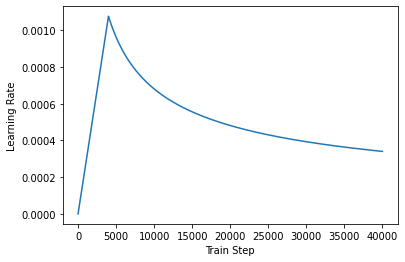

In [47]:
#test 
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 4.3. Loss and metrics

> Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.



In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 4.4. Training and checkpointing

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          en_input = input_vocab_size, 
                          en_target = target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

> Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every <code>n</code> epochs.



In [0]:
checkpoint_path = "./gdrive/My Drive/projects/transformer/ckpt/" 

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. tar_real is that same input shifted by 1: At each location in tar_input, tar_real contains the next token that should be predicted.

For example, sentence = "SOS A lion in the jungle is sleeping EOS"

tar_inp = "SOS A lion in the jungle is sleeping"

tar_real = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the text generation tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [0]:
EPOCHS = 10
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.


@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)


English is used as the input language and French is the target language.



In [0]:
# transformer.load_weights('./gdrive/My Drive/projects/transformer')


In [0]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/gdrive/My Drive/projects/transformer/logs/gradient_tape/' + current_time + '/train'
# # test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# # test_summary_writer = tf.summary.create_file_writer(test_log_dir)


In [58]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> English, tar -> French
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
  # tensorboard
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
  transformer.save_weights("./gdrive/My Drive/projects/transformer")

Epoch 1 Batch 0 Loss 1.7932 Accuracy 0.4147
Epoch 1 Batch 50 Loss 1.8225 Accuracy 0.3777
Epoch 1 Batch 100 Loss 1.8056 Accuracy 0.3787
Epoch 1 Batch 150 Loss 1.7997 Accuracy 0.3815
Epoch 1 Batch 200 Loss 1.7930 Accuracy 0.3818
Epoch 1 Batch 250 Loss 1.7889 Accuracy 0.3811
Epoch 1 Batch 300 Loss 1.7846 Accuracy 0.3813
Epoch 1 Batch 350 Loss 1.7822 Accuracy 0.3818
Epoch 1 Batch 400 Loss 1.7785 Accuracy 0.3820
Epoch 1 Batch 450 Loss 1.7761 Accuracy 0.3827
Epoch 1 Batch 500 Loss 1.7730 Accuracy 0.3832
Epoch 1 Batch 550 Loss 1.7723 Accuracy 0.3835
Epoch 1 Batch 600 Loss 1.7732 Accuracy 0.3835
Epoch 1 Batch 650 Loss 1.7728 Accuracy 0.3835
Epoch 1 Batch 700 Loss 1.7729 Accuracy 0.3837
Epoch 1 Batch 750 Loss 1.7745 Accuracy 0.3836
Epoch 1 Batch 800 Loss 1.7758 Accuracy 0.3838
Epoch 1 Batch 850 Loss 1.7765 Accuracy 0.3836
Epoch 1 Batch 900 Loss 1.7748 Accuracy 0.3837
Epoch 1 Batch 950 Loss 1.7741 Accuracy 0.3839
Epoch 1 Batch 1000 Loss 1.7748 Accuracy 0.3838
Epoch 1 Batch 1050 Loss 1.7744 Accur

In [0]:
# ckpt_save_path = ckpt_manager.save()

In [0]:
# transformer.save_weights("./gdrive/My Drive/projects/transformer")

# Part 5: Evaluating

The following steps are used for evaluation:

1.    Encode the input sentence using the English tokenizer (tokenizer_en). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
2.    The decoder input is the start token == tokenizer_fr.vocab_size.
3.    Calculate the padding masks and the look ahead masks.
4.    The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
5.    Select the last word and calculate the argmax of that.
6.    Concatentate the predicted word to the decoder input as pass it to the decoder.
7.    In this approach, the decoder predicts the next word based on the previous words it predicted.

In [0]:
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is English, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is French, the first word to the transformer should be the
  # French start token.
  decoder_input = [tokenizer_fr.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_fr.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights


In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_en.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_fr.decode([i]) for i in result 
                        if i < tokenizer_fr.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()


In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_fr.decode([i for i in result 
                                            if i < tokenizer_fr.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

Input: Where do you go?
Predicted translation: Où allez-vous ?


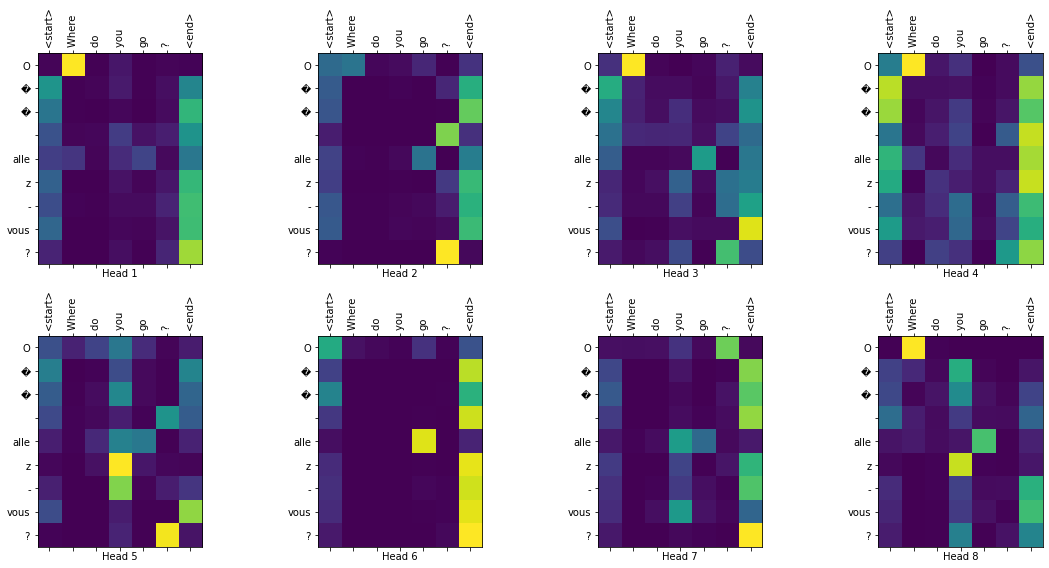

In [66]:
translate("Where do you go?",plot='decoder_layer4_block2')

Input: So I'll just share with you some stories very quickly of some magical things that have happened.
Predicted translation: Je partage donc très rapidement certaines choses qui ont été faites avec vous.


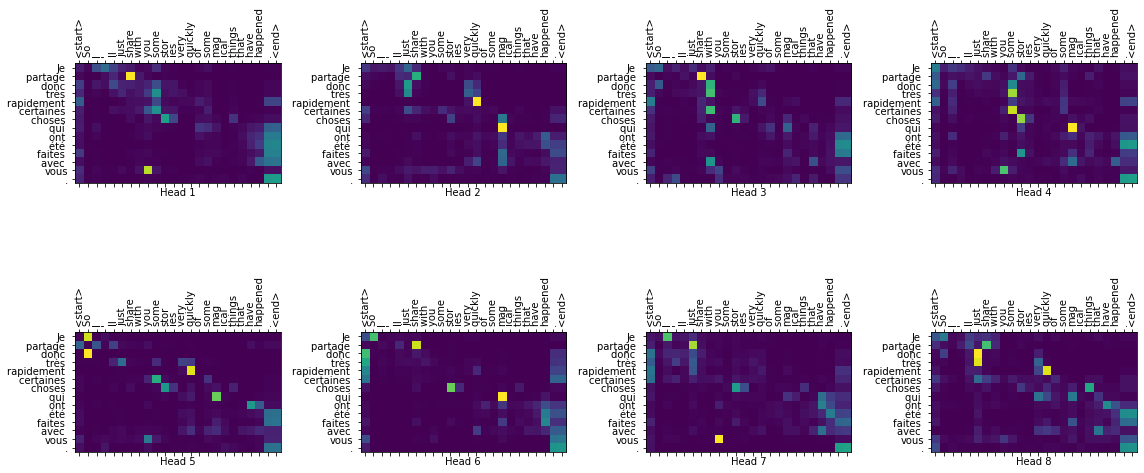

In [67]:
translate("So I'll just share with you some stories very quickly of some magical things that have happened.",plot='decoder_layer4_block2')

Input: This model is amazing!
Predicted translation: Ce modèle est surprenant !


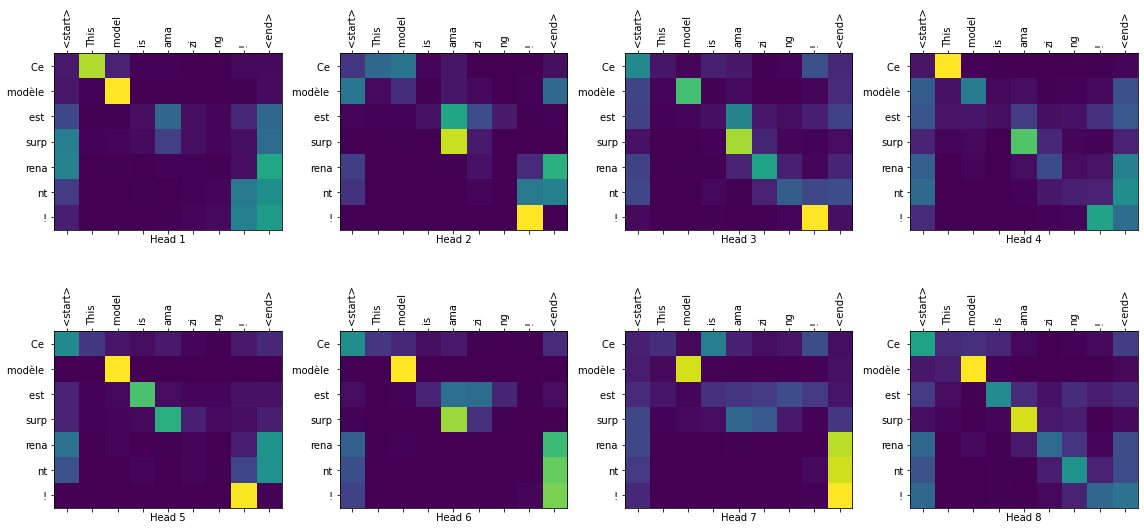

In [68]:
translate("This model is amazing!",plot='decoder_layer4_block2')

Input: Do you speak English?
Predicted translation: Parlez-vous anglais ?


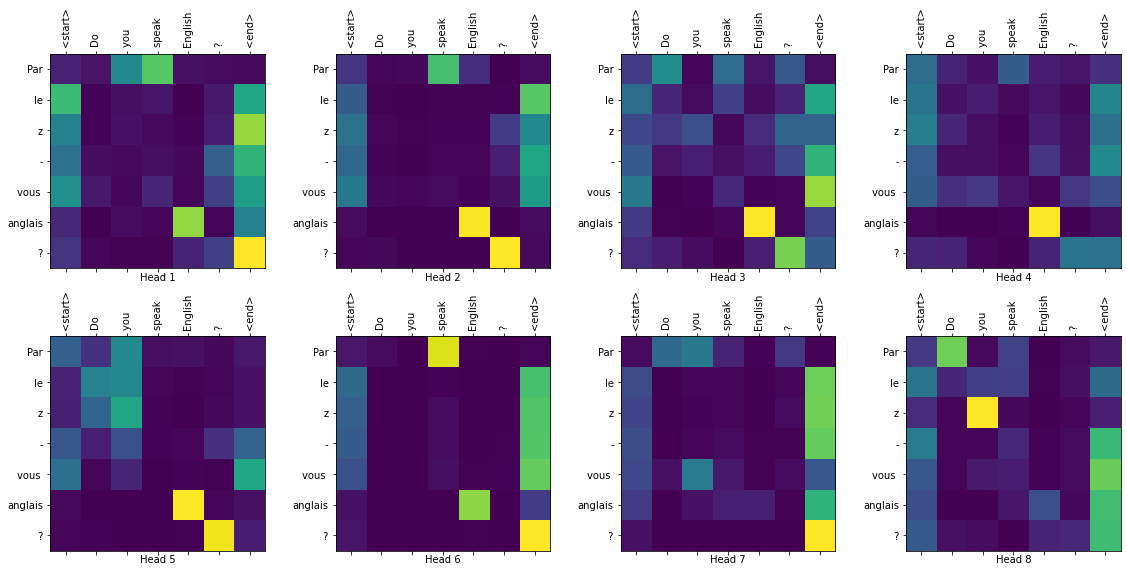

In [69]:
translate("Do you speak English?",plot='decoder_layer4_block2')

Input: This is a problem we have to solve.
Predicted translation: C'est un problème que nous devons résoudre.


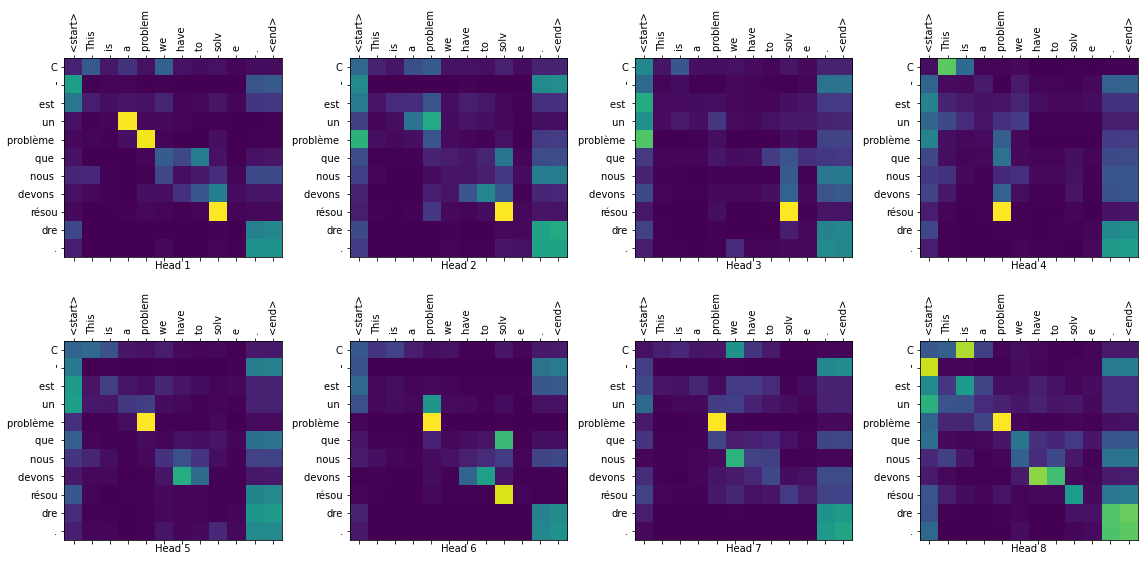

In [70]:
translate("This is a problem we have to solve.",plot='decoder_layer4_block2')